In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

neighborhoods = gpd.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/neighborhoods.geojson")
crime_df = pd.read_excel("https://data.wprdc.org/dataset/65e69ee3-93b2-4f7a-b9cb-8ce977f15d9a/resource/bd41992a-987a-4cca-8798-fbe1cd946b07/download/allmergedtables.xlsx")

crime_geo = [Point(xy) for xy in zip(crime_df['XCOORD'], crime_df['YCOORD'])]

crime = gpd.GeoDataFrame(crime_df, geometry=crime_geo)
crime.set_crs('EPSG:4326', allow_override=True, inplace=True);

# Step One
Our first step is to import GeoPoandas and matplotlib for creating visuals. In contrast to the trees data, the crime data is in the XLS fromat, so we need Pandas, and a geomerty library in order to process it into a format the GeoPandas recognizes. New we bring in the data from our [WPRDC](https://data.wprdc.org/dataset) source. Instead of downloading the data, I prefer to import it diretly from the database because these datasets are updated regularly.

We need to first convert the data into points using the shapely library. Then, we create a new geo data frame using this geometry. Finally, we set the Coordinate Reference System.

In [22]:
neighborhoods = neighborhoods.to_crs(crime.crs)

# Step Two
This step is optional with the trees data, but in this case its more important becuase we are seeting our own CRS for the crime data. This line of code ensures that both datasets are in the same Coordinate Reference System so that when we join the datasets they are aligned.

In [23]:
neighborhood_crime = gpd.sjoin(crime, neighborhoods, how="inner", predicate="within")
crime_count = neighborhood_crime.groupby("hood").size().reset_index(name='crime_count')

neighborhood_crime = neighborhoods.merge(crime_count, on="hood", how="left")
neighborhood_crime["crime_count"] = neighborhood_crime["crime_count"].fillna(0).astype(int)

# Step Three
This code first joins the two datasets, then groups the entries by neighborhood and counts the number of entires in each group. Next, it merges the data back into the neighborhoods data set. This gives us a list of neighborhoods with the amount of crime.

In [24]:
max_crime = neighborhood_crime['crime_count'].max()
neighborhood_crime['proportion'] = 1 - neighborhood_crime['crime_count'] / max_crime

neighborhood_crime = neighborhood_crime.sort_values(by='proportion', ascending=False)
neighborhood_crime.reset_index(drop=True, inplace=True)

# Step Four
This code creates a new index that ranks neighborhood crime rate inversely proportional to the neighborhood with the highest crime rate. This gives us a metric that we can plug into our master formula later. We also sort by this metric and reset the index.

In [25]:
crime_final = neighborhood_crime[['hood', 'crime_count', 'proportion']]

# Step Five
We create a new data frame that only contains the data that we'll need in the final formula.

# Step Six
The following code generates a plot of neighborhoods and colors the reigon by the crime rate. Finally, we print the ten neightborhoods with the lowest crime rate.

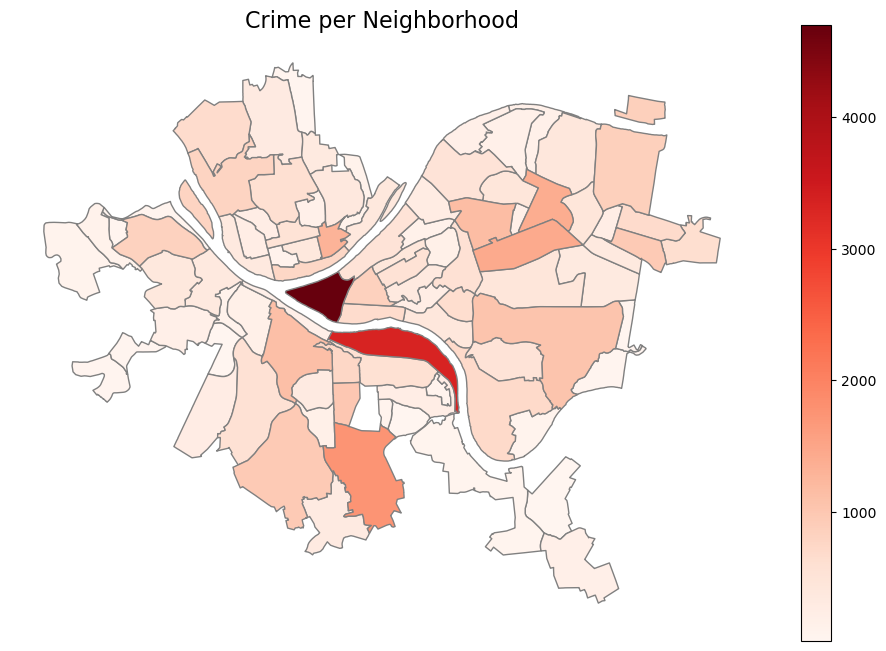

             hood  crime_count  proportion
0       St. Clair           23    0.995103
1       Ridgemont           24    0.994890
2   New Homestead           36    0.992336
3  Chartiers City           45    0.990419
4  Swisshelm Park           48    0.989781
5   Regent Square           55    0.988290
6     Summer Hill           58    0.987652
7   East Carnegie           58    0.987652
8         Oakwood           59    0.987439
9            Hays           69    0.985310


In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
neighborhood_crime.plot(
    column='crime_count',
    cmap='Reds',
    ax=ax,
    legend=True,
    edgecolor='gray'
)

ax.set_title("Crime per Neighborhood", fontsize=16)
ax.axis("off")
plt.show()

print(crime_final.head(10))